<a href="https://colab.research.google.com/github/LucaM185/MLgit/blob/main/AttentionBlock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget -O dataset.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


--2023-11-23 15:30:09--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-11-23 15:30:09 (21.5 MB/s) - ‘dataset.txt’ saved [1115394/1115394]



In [2]:
import requests
import gzip
import shutil

# https://openlibrary.org/developers/dumps
url = "https://openlibrary.org/data/ol_dump_authors_latest.txt.gz"

file_path = "ol_dump_editions_latest.txt.gz"

response = requests.get(url, stream=True)
with open(file_path, "wb") as file:
    shutil.copyfileobj(response.raw, file, length=16*1024*1024)  # Increase buffer size

unpacked_file_path = "dataset.txt"
with gzip.open(file_path, "rb") as gz_file:
    with open(unpacked_file_path, "wb") as file:
        shutil.copyfileobj(gz_file, file)

## Its going to take around a minute for 500 MB


KeyboardInterrupt: ignored

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
with open("dataset.txt", "r") as f:
    text = f.read()
print(text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [5]:
load = text[:30000000]

In [6]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]
device = torch.device("cuda:0")

sequence_length = 16
X = torch.tensor(dataset)
# nn.ModuleDict

In [10]:
class FullyConnected(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.fc1 = nn.Linear(sequence_length*config.head_size*config.n_heads, 200)
        self.LayerNorm1 = nn.LayerNorm(200)
        self.fc2 = nn.Linear(200, 200)
        self.LayerNorm2 = nn.LayerNorm(200)
        self.out = nn.Linear(200, config.vocab_size)

    def forward(self, x):
        x = x.view(x.shape[0], sequence_length*self.config.head_size*self.config.n_heads)
        x = F.gelu(self.fc1(x))
        x = self.LayerNorm1(x)
        x = F.gelu(self.fc2(x))
        x = self.LayerNorm2(x)
        x = self.out(x)
        return x

class Attention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.pemb = nn.Embedding(sequence_length, config.emb_size)
        self.wemb = nn.Embedding(config.vocab_size, config.emb_size)

        self.keys = nn.Linear(config.emb_size, config.head_size)
        self.queries = nn.Linear(config.emb_size, config.head_size)
        self.values = nn.Linear(config.emb_size, config.head_size)

    def forward(self, data):
        # embeddings
        pemb = self.pemb(torch.arange(sequence_length).to(device)).view(1, sequence_length, self.config.emb_size) # [time, emb_size]
        wemb = self.wemb(data)        # [Batch_size, time, emb_size]

        embeddings = wemb + pemb

        # attention
        k = self.keys(embeddings)     # [Batch_size, time, head_size]
        q = self.queries(embeddings)  # [Batch_size, time, head_size]
        v = self.values(embeddings)   # [Batch_size, time, head_size]

        similarity = k @ q.transpose(-2, -1)/(self.config.head_size**0.5)
        similarity = torch.tril(similarity)  # [Batch_size, time, time]
        similarity[similarity == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        attention = similarity @ v    # [Batch_size, time, head_size]
        return attention

class GPTconfig():
    pass


class Model(nn.Module):
    def __init__(self):
        super().__init__()

        config = GPTconfig()
        config.vocab_size = X.max() + 1
        config.head_size = 20
        config.emb_size = 25
        config.n_heads = 1
        self.config = config

        self.att = nn.ModuleList([Attention(config) for i in range(config.n_heads)])
        self.fc = FullyConnected(config)


    def forward(self, x):  # inputs: [Batch_size, time, vocab_size]

        batch_size = x.shape[0]
        x = x.to(device)

        x = torch.cat([attention(x) for attention in self.att]).view(batch_size, self.config.head_size*self.config.n_heads*sequence_length)
        x = self.fc(x)

        return x


Net = Model().to(device)
lossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in Net.parameters() if p.requires_grad)/1000000, 2))

Millions of parameters:  0.12


In [11]:
%%time
epochs = 1500
batch_size = 50
print("Percent of dataset: ", epochs*batch_size / X.shape[0])

optimizer = torch.optim.Adam(Net.parameters(), lr=3e-4)

for epoch in tqdm(range(epochs)):
    indexes = torch.randint(len(dataset)-sequence_length-2, (batch_size, )).repeat(sequence_length).view(sequence_length, batch_size).T + torch.arange(sequence_length)

    pred = Net(X[indexes].to(device))
    loss = F.cross_entropy(pred, (X[indexes[:, -1] + 1]).to(device))
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


Percent of dataset:  0.06724081356005143


100%|██████████| 1500/1500 [00:06<00:00, 248.06it/s]

CPU times: user 5.54 s, sys: 130 ms, total: 5.67 s
Wall time: 6.05 s


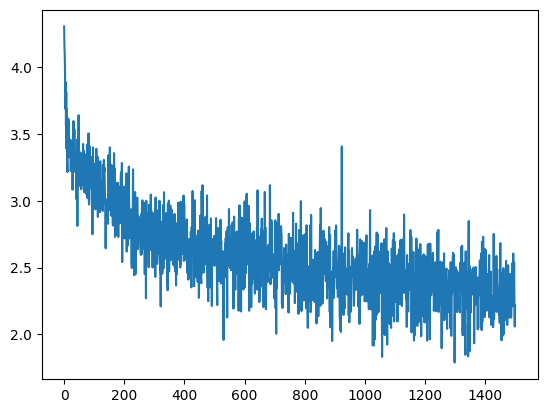

In [12]:
plt.plot(lossi[:])

In [13]:
torch.tensor(lossi[-100:]).mean() # Best: 1.23 / 1.66

tensor(2.3090)

In [14]:
# LAYERNORM IS CRAZY IMPORTANT

In [15]:
prompt = "                       hi, "

for i in range(100):
    ints = torch.tensor([texttoint[elm] for elm in prompt[-sequence_length:]])
    prompt += inttotext[torch.multinomial(F.softmax(Net(ints.view(1, -1)), dim=1)**2, num_samples=1).item()]
    # prompt += inttotext[Net(ints.view(1, -1)).argmax().item()]

In [16]:
print(prompt)

                       hi, trom the you man sit st heake st me chern hat st fam he cure not an the fragl,
Wo ouelis wis reat so


In [88]:
[i for i in Net.att[0].parameters()]

[Parameter containing:
 tensor([[ 1.5619,  0.6218,  0.3209, -1.2173,  1.1372,  0.5329, -0.1240,  0.3764,
          -0.6359, -0.4306,  0.3778,  1.4458, -1.9163, -1.2707, -0.5457,  1.4190,
          -0.6964,  0.0748,  0.5390,  0.0648,  0.2239, -2.1888,  0.1216, -2.1923,
          -1.2689],
         [ 0.1838, -0.2107, -0.3673,  0.7873, -0.0768,  1.1750, -0.4967, -0.0461,
          -1.3621, -0.4267,  1.2114,  0.1197,  0.8962, -1.5152,  0.3915,  0.0911,
           1.0144,  0.3347, -0.9224, -0.8775, -0.6748, -1.1060, -0.0264,  0.4975,
           1.9380],
         [-0.1169,  0.7184, -0.2843,  0.5812,  0.9150, -0.3875,  0.9016, -0.7153,
          -0.1954,  0.3633,  0.2610, -2.5185, -0.2069,  0.3186, -1.4511,  1.1092,
           0.7869,  0.2767, -0.1174, -1.6665,  0.9025, -0.0297,  1.6635,  1.3615,
          -1.0747],
         [-0.5056, -0.0053,  0.1304,  0.1502, -0.5802,  1.0883,  0.8149,  0.0910,
          -0.4835, -0.6517,  1.8391, -0.7913, -1.4981,  1.4628,  1.1967, -0.0795,
          -1.57